In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:0


In [2]:
loss_thresh = 25000
level = "_low"
label = "Burgers_stan" + level

T0 = 300
pi = 3.14
rho = 1
c_p = 1
k = 0.001

x = np.linspace(-1,1,10).reshape(-1,1)
y = np.linspace(-1,1,10).reshape(-1,1)
z = np.linspace(-1,1,10).reshape(-1,1)
t = np.linspace(0,10,10).reshape(-1,1)

X,Y,Z,T = np.meshgrid(x,y,z,t)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xyzt = np.hstack((X,Y,Z,T))

# bound_pts_1 = (X == 0).reshape(-1,)
# bound_pts_2 = np.logical_and(Y == 0,X != 0).reshape(-1,)
# bound_pts_3 = np.logical_and(X == 1,Y != 0).reshape(-1,) 
# bound_pts_4 = np.logical_and(Y == 1,X != 1).reshape(-1,) 

# xy_bound_1 = xy[bound_pts_1,:]
# xy_bound_2 = xy[bound_pts_2,:]
# xy_bound_3 = xy[bound_pts_3,:]
# xy_bound_4 = xy[bound_pts_4,:]

# u_bound_1 = 1000*np.ones((np.shape(xy_bound_1)[0],1))
# u_bound_2 = 800*np.ones((np.shape(xy_bound_2)[0],1))
# u_bound_3 = 500*np.ones((np.shape(xy_bound_3)[0],1))
# u_bound_4 = np.zeros((np.shape(xy_bound_4)[0],1))

# xy_bound = np.vstack((xy_bound_1,xy_bound_2,xy_bound_3,xy_bound_4))
# u_bound = np.vstack((u_bound_1,u_bound_2,u_bound_3,u_bound_4))

# xy_test_tensor = torch.from_numpy(xy).float().to(device)

lb_xyzt = xyzt[0]
ub_xyzt = xyzt[-1]

In [3]:
def trainingdata(N_I,N_T,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #Side 1 
    x_1 = x[0]*np.ones((N_T,1))
    y_1 = np.random.uniform(y[0],y[-1],(N_T,1))
    z_1 = np.random.uniform(z[0],z[-1],(N_T,1))
    t_1 = np.random.uniform(t[0],t[-1],(N_T,1))
    xyzt_1 = np.hstack((x_1,y_1,z_1,t_1))
    u_1 = T0*np.ones((N_T,1))
    
    #Side 2
    x_2 = np.random.uniform(x[0],x[-1],(N_T,1))
    y_2 = y[0]*np.ones((N_T,1))
    z_2 = np.random.uniform(z[0],z[-1],(N_T,1))
    t_2 = np.random.uniform(t[0],t[-1],(N_T,1))
    xyzt_2 = np.hstack((x_2,y_2,z_2,t_2))
    u_2 = T0*np.ones((N_T,1))
    
    #Side 3
    x_3 = x[-1]*np.ones((N_T,1))
    y_3 = np.random.uniform(y[0],y[-1],(N_T,1))
    z_3 = np.random.uniform(z[0],z[-1],(N_T,1))
    t_3 = np.random.uniform(t[0],t[-1],(N_T,1))
    xyzt_3 = np.hstack((x_3,y_3,z_3,t_3))
    u_3 = T0*np.ones((N_T,1))
    
    #Side 4
    x_4 = np.random.uniform(x[0],x[-1],(N_T,1))
    y_4 = y[-1]*np.ones((N_T,1))
    z_4 = np.random.uniform(z[0],z[-1],(N_T,1))
    t_4 = np.random.uniform(t[0],t[-1],(N_T,1))
    xyzt_4 = np.hstack((x_4,y_4,z_4,t_4))
    u_4 = T0*np.ones((N_T,1))
    
    #Side 4
    x_4 = np.random.uniform(x[0],x[-1],(N_T,1))
    y_4 = y[-1]*np.ones((N_T,1))
    z_4 = np.random.uniform(z[0],z[-1],(N_T,1))
    t_4 = np.random.uniform(t[0],t[-1],(N_T,1))
    xyzt_4 = np.hstack((x_4,y_4,z_4,t_4))
    u_4 = T0*np.ones((N_T,1))
    
    #Top side
    x_5 = np.random.uniform(x[0],x[-1],(N_T,1))
    y_5 = np.random.uniform(y[0],y[-1],(N_T,1))
    z_5 = z[-1]*np.ones((N_T,1))
    t_5 = np.random.uniform(t[0],t[-1],(N_T,1))
    xyzt_5 = np.hstack((x_5,y_5,z_5,t_5))
    u_5 = T0*np.ones((N_T,1))
    
    #Bottom side
    x_6 = np.random.uniform(x[0],x[-1],(N_T,1))
    y_6 = np.random.uniform(y[0],y[-1],(N_T,1))
    z_6 = z[0]*np.ones((N_T,1))
    t_6 = np.random.uniform(t[0],t[-1],(N_T,1))
    xyzt_6 = np.hstack((x_5,y_5,z_5,t_5))
    u_6 = T0*np.ones((N_T,1))
    
    #Initial Condition
    xyz_0 = np.random.uniform(x[0],x[-1],(N_I,3))
    t_0 = t[0]*np.ones((N_I,1))
    xyzt_0 = np.hstack((xyz_0,t_0))
    u_0 = T0*np.ones((N_I,1))
    
    xyzt_BC = np.vstack((xyzt_1,xyzt_2,xyzt_3,xyzt_4,xyzt_5,xyzt_6,xyzt_0)) #choose indices from  set 'idx' (x,t)
    u_BC = np.vstack((u_1,u_2,u_3,u_4,u_5,u_6,u_0))
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0],[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xyzt_coll = lb_xyzt + (ub_xyzt - lb_xyzt)*samples
    
#     rthetat_coll = lb_rthetat + (ub_rthetat - lb_rthetat)*samples
#     x_coll2 = rthetat_coll[:,0]*np.sin(rthetat_coll[:,1])
#     y_coll2 = rthetat_coll[:,0]*np.cos(rthetat_coll[:,1])
#     xyt_coll2 = np.hstack((x_coll2.reshape(-1,1),y_coll2.reshape(-1,1),rthetat_coll[:,2].reshape(-1,1)))
    
    
    #Additional Collocation 
    # x_c_coll = np.random.normal(0,0.05,(N_T,1))
    # t_c_coll = np.abs(np.random.normal(0,0.05,(N_T,1)))
    # xt_c_coll = np.hstack((x_c_coll,t_c_coll))

    xyzt_coll = np.vstack((xyzt_coll, xyzt_BC)) # append training points to collocation points 

    return xyzt_coll, xyzt_BC, u_BC

In [4]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        beta_mean = 1.0*torch.ones((50,len(layers)-2))
        beta_std = 0.1*torch.ones((50,len(layers)-2))
        
        self.beta = Parameter(torch.normal(beta_mean,beta_std))
        self.beta.requiresGrad = True
            
    'foward pass'
    def forward(self,xyzt):
        if torch.is_tensor(xyzt) != True:         
            xyt = torch.from_numpy(xyzt)                
        
        ubxyzt = torch.from_numpy(ub_xyzt).float().to(device)
        lbxyzt = torch.from_numpy(lb_xyzt).float().to(device)
    
                      
        #preprocessing input 
        xyzt = 2.0*(xyzt - lbxyzt)/(ubxyzt - lbxyzt) - 1.0
        
        #convert to float
        a = xyzt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 =self.activation(z)
            a = z1 + self.beta[:,i]*z*z1
       
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xyzt,u):
                
        loss_bc = self.loss_function(self.forward(xyzt), u)
                
        return loss_bc
    
    def loss_PDE(self, xyzt_coll, f_hat):
        
        g = xyzt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y_z_t = autograd.grad(u,g,torch.ones([xyzt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy_zz_tt = autograd.grad(u_x_y_z_t,g,torch.ones(xyzt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dt = u_x_y_z_t[:,[3]]
        
        d2u_dx2 = u_xx_yy_zz_tt[:,[0]]
        d2u_dy2 = u_xx_yy_zz_tt[:,[1]]
        d2u_dz2 = u_xx_yy_zz_tt[:,[2]]
        
        #Heat source Gaussian Distributed in x and t
        sigma_x = 0.05
        sigma_t = 0.1
        exp_term1 = (torch.square(g[:,0].reshape(-1,1)) + torch.square(g[:,1].reshape(-1,1))+torch.square(g[:,2].reshape(-1,1)))/sigma_x**2
        exp_term2 =  torch.square(g[:,3].reshape(-1,1))/sigma_t**2
        
        Q = 1000.0*torch.exp(-0.5*(exp_term1 + exp_term2))/(np.sqrt(((2*pi)**4)*sigma_x*sigma_x*sigma_x*sigma_t)) 
        
        f = rho*c_p*du_dt - k*(d2u_dx2+d2u_dy2+d2u_dz2) - Q
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xyzt_BC,u_BC,xyzt_coll,f_hat):

        loss_BC = self.loss_BC(xyzt_BC,u_BC)
        loss_f = self.loss_PDE(xyzt_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
         
    'test neural network'
    def test(self):
        # u_pred = self.forward(xt_test_tensor)
        # u_pred = u_pred.cpu().detach().numpy()
        u_pred = 0
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
        
        # test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        # test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        test_mse = 0
        test_re = 0
        
        return test_mse, test_re 

In [5]:
def data_update(loss_np):
    train_loss.append(loss_np)

    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [6]:
def train_step(xyzt_BC,u_BC,xyzt_coll,f_hat,seed):

    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xyzt_BC,u_BC,xyzt_coll,f_hat)
        loss.backward()
        #print(loss.cpu().detach().numpy())
        return loss

    optimizer.step(closure)

In [7]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*9)
    start_time = time.time() 
    thresh_flag = 0

    xyzt_coll_np_array, xyzt_BC_np_array, u_BC_np_array = trainingdata(N_I,N_T,N_f,rep*22)
        
    xyzt_coll = torch.from_numpy(xyzt_coll_np_array).float().to(device)
    xyzt_BC = torch.from_numpy(xyzt_BC_np_array).float().to(device)
    u_BC = torch.from_numpy(u_BC_np_array).float().to(device)
        
    f_hat = torch.zeros(xyzt_coll.shape[0],1).to(device)
    

    for i in range(max_iter):
        train_step(xyzt_BC,u_BC,xyzt_coll,f_hat,i)
        loss_np = PINN.loss(xyzt_BC,u_BC,xyzt_coll,f_hat).cpu().detach().numpy()
        
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1          
                thresh_flag = 1       
        data_update(loss_np)
        
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])   
        
    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))

In [8]:
max_reps = 1
max_iter = 500 #200

train_loss_full = []
test_mse_full = []
test_re_full = []

elapsed_time= np.zeros((max_reps,1))
time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))



N_T = 20000 #Total number of data points for 'y'
N_I = 40000
N_f = 100000 #Total number of collocation points 


for reps in range(max_reps):
    print(label)
    print(reps)
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
 
    
    torch.manual_seed(reps*36)
    
    layers = np.array([4,50,50,50,50,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.25, 
                              max_iter = 20, 
                              max_eval = 30, 
                              tolerance_grad = 1e-08, 
                              tolerance_change = 1e-08, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



   
    
    nan_flag = train_model(max_iter,reps)
    
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    #elapsed_time[reps] = time.time() - start_time



    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

Burgers_stan_low
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 646.99365 Test MSE 0 Test RE 0
1 Train Loss 545.428 Test MSE 0 Test RE 0
2 Train Loss 540.21326 Test MSE 0 Test RE 0
3 Train Loss 538.63007 Test MSE 0 Test RE 0
4 Train Loss 538.1881 Test MSE 0 Test RE 0
5 Train Loss 538.0415 Test MSE 0 Test RE 0
6 Train Loss 537.96454 Test MSE 0 Test RE 0
7 Train Loss 537.91095 Test MSE 0 Test RE 0
8 Train Loss 537.8459 Test MSE 0 Test RE 0
9 Train Lo

In [14]:
x = np.linspace(-0.2,0.2,100).reshape(-1,1)
y = np.linspace(-0.2,0.2,100).reshape(-1,1)
z = np.linspace(-0.2,0.2,100).reshape(-1,1)
t = 0.1

X,Y,Z,T = np.meshgrid(x,y,z,t)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xyzt = np.hstack((X,Y,Z,T))


xyzt_test_tensor = torch.from_numpy(xyzt).float().to(device)

u_pred = PINN.forward(xyzt_test_tensor).cpu().detach().numpy()
# u_true_t2 = T0+ np.exp(-1*np.square(x)/(4*a*y))/(rho*c_p*np.sqrt(4*p/i*a*y))

In [58]:
r = np.linspace(0.0,0.4,100).reshape(-1,1)
theta = np.zeros((100,1))
phi = np.zeros((100,1))
t = 0.05*np.ones((100,1))

xyzt = np.hstack((r*np.sin(phi)*np.cos(theta),r*np.sin(phi)*np.sin(theta),r*np.cos(phi),t))
xyzt_test_tensor = torch.from_numpy(xyzt).float().to(device)

u_pred= PINN.forward(xyzt_test_tensor).cpu().detach().numpy()


In [59]:
r = np.linspace(0.0,0.4,100).reshape(-1,1)
theta = np.zeros((100,1))
phi = np.zeros((100,1))
t = 0.5*np.ones((100,1))

xyzt = np.hstack((r*np.sin(phi)*np.cos(theta),r*np.sin(phi)*np.sin(theta),r*np.cos(phi),t))
xyzt_test_tensor = torch.from_numpy(xyzt).float().to(device)

u_pred1= PINN.forward(xyzt_test_tensor).cpu().detach().numpy()


In [60]:
r = np.linspace(0.0,0.4,100).reshape(-1,1)
theta = np.zeros((100,1))
phi = np.zeros((100,1))
t = 0.75*np.ones((100,1))

xyzt = np.hstack((r*np.sin(phi)*np.cos(theta),r*np.sin(phi)*np.sin(theta),r*np.cos(phi),t))
xyzt_test_tensor = torch.from_numpy(xyzt).float().to(device)

u_pred2= PINN.forward(xyzt_test_tensor).cpu().detach().numpy()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


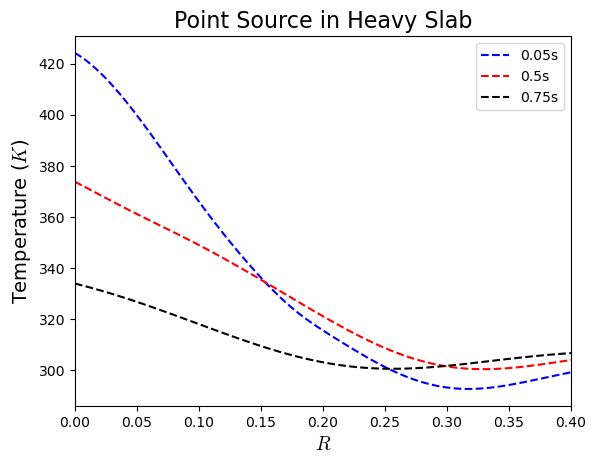

In [67]:
fig,ax = plt.subplots()
ax.plot(r,u_pred,'b--',label = '0.05s')
# ax.plot(x,u_true_t1,'b')
ax.plot(r,u_pred1,'r--',label = '0.5s')
# ax.plot(x,u_true_t2,'r')
ax.plot(r,u_pred2,'k--',label = '0.75s')
# ax.plot(x,u_true_t3,'k')
ax.legend()
ax.set_xlabel('$R$',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('Temperature ($K$)',math_fontfamily = 'cm',fontsize = 14)
ax.set_title('Point Source in Heavy Slab',math_fontfamily = 'cm',fontsize = 16)
ax.set_xlim([0.,0.4])
plt.savefig('Grong_3D.svg',format = 'svg',bbox_inches = 'tight')
plt.savefig('Grong_3D.png',format = 'png',bbox_inches = 'tight')
plt.savefig('Grong_3D.eps',format = 'eps',bbox_inches = 'tight')

In [ ]:
plt.imshow(u_pred1.reshape(200,200),cmap = 'jet')

In [ ]:
x = np.linspace(-0.2,0.2,200).reshape(-1,1)
y = np.linspace(-0.2,0.2,200).reshape(-1,1)
t = 5

X,Y,T = np.meshgrid(x,y,t)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xyt = np.hstack((X,Y,T))

xyt_test_tensor = torch.from_numpy(xyt).float().to(device)

u_pred1 = PINN.forward(xyt_test_tensor).cpu().detach().numpy()
# u_true_t2 = T0+ np.exp(-1*np.square(x)/(4*a*y))/(rho*c_p*np.sqrt(4*p/i*a*y))

In [ ]:
X,Y = np.meshgrid(x,y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, u_pred.reshape(200,200), cmap='jet',linewidth=0, antialiased=False)
# ax.plot_surface(X, Y, u_pred1.reshape(200,200), cmap='jet',linewidth=0, antialiased=False)
ax.plot(np.zeros(10,),np.zeros(10,),np.linspace(300,335,10),'k',linewidth=3)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Draw a circle on the x=0 'wall'
p = Circle((5, 5), 3)
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="x")


In [ ]:
u_pred.shape

In [ ]:
x = np.linspace(-0.2,0.2,500).reshape(-1,1)
# y = np.linspace(0,1,500).reshape(-1,1)
y = 5

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
  
xy = np.hstack((X,Y))

xy_test_tensor = torch.from_numpy(xy).float().to(device)

u_pred_t3 = PINN.forward(xy_test_tensor).cpu().detach().numpy()
u_true_t3 = T0+ np.exp(-1*np.square(x)/(4*a*y))/(rho*c_p*np.sqrt(4*pi*a*y))

In [ ]:
fig,ax = plt.subplots()
ax.plot(x,u_pred_t1,'b--',label = '0.1s')
# ax.plot(x,u_true_t1,'b')
ax.plot(x,u_pred_t2,'r--',label = '1s')
# ax.plot(x,u_true_t2,'r')
ax.plot(x,u_pred_t3,'k--',label = '5s')
# ax.plot(x,u_true_t3,'k')
ax.legend()
ax.set_xlabel('$x$',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('Temperature ($K$)',math_fontfamily = 'cm',fontsize = 14)
ax.set_title('Instantaneous Heat Source on a Rod',math_fontfamily = 'cm',fontsize = 16)

In [ ]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.flip(u_pred.reshape(500,500),axis = 0),cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
